In [16]:
import praw
import pandas as pd
import time
import re
from datetime import datetime
from tqdm import tqdm

REDDIT_CLIENT_ID = 'd81fZJdJa2L9odh3XWxUBw'
REDDIT_CLIENT_SECRET = 'M_5WlDMS6ZPqfJVMzOHvVKl5fkY-RA'
REDDIT_USER_AGENT = 'script:mental_health_monitor:1.0 (by u/KeyBee3714)'
suicidal_keywords = [
    "i want to die", "kill myself", "suicide note", "ending it all", "not worth living",
    "i can't go on", "ending my life", "want to end it"
]


subreddits = ["SuicideWatch", "depression", "mentalhealth", "offmychest", "TrueOffMyChest"]

keyword_pattern = re.compile('|'.join(map(re.escape, suicidal_keywords)), re.IGNORECASE)


data = []
MAX_USERS = 1000

def is_suicidal(text):
    return bool(keyword_pattern.search(text))

def collect_user_data():
    seen_users = set()
    for sub in subreddits:
        subreddit = reddit.subreddit(sub)
        print(f"Collecting from r/{sub}...")
        
        for post in tqdm(subreddit.new(limit=1000)):
            if not post.author or post.author.name in seen_users:
                continue
            
            if is_suicidal(post.title + ' ' + (post.selftext or '')):
                username = post.author.name
                seen_users.add(username)
                
                data.append({
                    "user": username,
                    "type": "suicidal_post",
                    "subreddit": sub,
                    "created_utc": datetime.fromtimestamp(post.created_utc),
                    "text": post.title + ' ' + (post.selftext or '')
                })

                try:
                    for user_post in reddit.redditor(username).submissions.new(limit=30):
                        if user_post.id != post.id and user_post.created_utc < post.created_utc:
                            data.append({
                                "user": username,
                                "type": "historical_post",
                                "subreddit": user_post.subreddit.display_name,
                                "created_utc": datetime.fromtimestamp(user_post.created_utc),
                                "text": user_post.title + ' ' + (user_post.selftext or '')
                            })
                    for comment in reddit.redditor(username).comments.new(limit=30):
                        if comment.created_utc < post.created_utc:
                            data.append({
                                "user": username,
                                "type": "historical_comment",
                                "subreddit": comment.subreddit.display_name,
                                "created_utc": datetime.fromtimestamp(comment.created_utc),
                                "text": comment.body
                            })
                except Exception as e:
                    print(f"Error fetching history for {username}: {e}")
                
            if len(seen_users) >= MAX_USERS:
                break
        if len(seen_users) >= MAX_USERS:
            break

collect_user_data()

df = pd.DataFrame(data)
df.to_csv("suicidal_user_behavior_dataset.csv", index=False)
print(f"Saved {len(df)} rows to suicidal_user_behavior_dataset.csv")


678it [02:23,  4.56it/s]

Error fetching history for Im_a_KitchenSink1: received 403 HTTP response


858it [03:07,  7.42it/s]

Error fetching history for pink_kittii: received 403 HTTP response


984it [03:30,  4.67it/s]


157it [00:14,  7.07it/s]

Error fetching history for Capital-Sale1489: received 403 HTTP response


986it [01:48,  9.12it/s]


786it [00:38, 10.94it/s]

Error fetching history for Smooth_Layer_5410: received 403 HTTP response


970it [00:45, 21.50it/s]


551it [00:19, 46.81it/s]

Error fetching history for 888877776666huihui: received 403 HTTP response


980it [00:31, 31.25it/s]


928it [00:38, 24.13it/s]

Saved 8184 rows to suicidal_user_behavior_dataset.csv


In [18]:
import pandas as pd
df= pd.read_csv(r"suicidal_user_behavior_dataset.csv")
df

,user,type,subreddit,created_utc,text
0,WearyIdeal1912,suicidal_post,SuicideWatch,2025-05-11 09:34:12,Why?! my body prevent me from doing anything ...
1,WearyIdeal1912,historical_post,SuicideWatch,2025-05-11 04:14:45,"I’m Already Gone Just Not Buried Yet Lately, I..."
2,WearyIdeal1912,historical_post,SuicideWatch,2025-05-11 03:42:05,If anyone knows plz [removed]
3,WearyIdeal1912,historical_post,depression,2024-12-05 19:54:27,[ Removed by Reddit ] [removed]
4,WearyIdeal1912,historical_comment,SuicideWatch,2025-05-11 09:26:26,"Thank you for your reply, I have never taken a..."
...,...,...,...,...,...
8179,thissucksandisuck,historical_comment,ProjectSekai,2022-12-26 23:27:55,Leek
8180,thissucksandisuck,historical_comment,ProjectSekai,2022-11-30 23:21:24,"MMJ could be a string quartet, with Haruka and..."
8181,thissucksandisuck,historical_comment,ProjectSekai,2022-08-23 23:01:10,Not sure if these count as unpopular opinions ...
8182,thissucksandisuck,historical_comment,tipofmytongue,2022-07-25 00:34:33,"Unfortunately, no. It had four words. But than..."


In [23]:
df['user'].nunique()

331

In [24]:
df.isnull().sum()

user           0
type           0
subreddit      0
created_utc    0
text           0
dtype: int64

In [25]:
df['created_utc'] = pd.to_datetime(df['created_utc'])
df.sort_values(by=['user', 'created_utc'], inplace=True)

In [26]:
from collections import defaultdict

user_sequences = defaultdict(list)

for _, row in df.iterrows():
    entry = {
        'text': row['text'],
        'timestamp': row['created_utc'],
        'type': row['type'],
        'subreddit': row['subreddit']
    }
    user_sequences[row['user']].append(entry)


In [27]:
user_labels = {}
for user, posts in user_sequences.items():
    user_labels[user] = 1 if any(p['type'] == 'suicidal_post' for p in posts) else 0

In [28]:
from datetime import datetime

for user, posts in user_sequences.items():
    first_time = posts[0]['timestamp']
    for post in posts:
        post['time_since_first'] = (post['timestamp'] - first_time).total_seconds()
        post['hour'] = post['timestamp'].hour

In [29]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_posts = 10
max_length = 512

user_inputs = {}
for user, posts in user_sequences.items():
    combined_text = " ".join([p['text'] for p in posts[-max_posts:]])  # take last N posts
    encoding = tokenizer(combined_text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    user_inputs[user] = encoding


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\THINKPAD\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\THINKPAD\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
import torch
from torch.utils.data import Dataset

class SuicidalIdeationDataset(Dataset):
    def __init__(self, user_inputs, user_labels):
        self.users = list(user_inputs.keys())
        self.inputs = user_inputs
        self.labels = user_labels

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        encoding = self.inputs[user]
        label = torch.tensor(self.labels[user], dtype=torch.long)
        return {**encoding, 'labels': label}


In [34]:
user_data = []
for user, posts in user_sequences.items():
    combined_text = " ".join([p['text'] for p in posts[-10:]])
    label = user_labels[user]
    time_deltas = [p['time_since_first'] for p in posts[-10:]]
    hours = [p['hour'] for p in posts[-10:]]
    user_data.append({
        'user': user,
        'label': label,
        'combined_text': combined_text,
        'time_deltas': time_deltas,
        'hours': hours
    })

preprocessed_df = pd.DataFrame(user_data)
preprocessed_df

,user,label,combined_text,time_deltas,hours
0,1LifeThrownAway,1,I have no romantic experience at 25 Throwaway ...,[0.0],[2]
1,21hainjo,1,M M Jdbdbsj [removed] Hdjjd jdjdjdjdnzkdi [r...,"[0.0, 12.0, 2543079.0, 5639690.0, 39535469.0, ...","[22, 22, 8, 4, 12, 11, 22, 12, 12, 7]"
2,666nbnici,1,I was scared of jowling because I heard so muc...,"[30924657.0, 30924693.0, 30926637.0, 30927932....","[21, 21, 22, 22, 11, 18, 19, 20, 18, 18]"
3,888877776666huihui,1,I'm super scared and nervous 18f My hands are ...,[0.0],[18]
4,Academic_Mood6384,1,"Hi, Moldova, Chisinau (capital) city center, o...","[0.0, 1174.0, 1378.0, 2177.0, 2613.0, 2704.0, ...","[17, 17, 17, 18, 18, 18, 20, 20]"
...,...,...,...,...,...
326,xbalanqe,1,"yes thats what I wanted to know, thank you! I ...","[18985499.0, 18986153.0, 20128878.0, 20456186....","[23, 23, 4, 23, 4, 4, 4, 2, 2, 0]"
327,ysyeblue,1,multiple dedication Si te gusta lo psicológic...,"[5373026.0, 5422498.0, 5464117.0, 5730084.0, 5...","[5, 19, 6, 8, 2, 2, 8, 3, 1, 6]"
328,yuh_hoe,1,its frustrating !! oyeee My Parents Are Refusi...,"[29198781.0, 29200572.0, 29388398.0, 29388514....","[6, 7, 11, 11, 14, 8, 9, 4, 15, 15]"
329,zekelbomb,1,"Aphrodite, Your Electric Sexiness by human zoo...","[79997402.0, 79997876.0, 82457506.0, 86380298....","[2, 2, 14, 23, 23, 3, 8, 5, 13, 12]"


In [32]:
preprocessed_df.to_csv("preprocessed_dataset.csv", index=False)

In [35]:
preprocessed_df['label'].value_counts()

label
1    331
Name: count, dtype: int64

In [38]:
import requests
reddit = praw.Reddit(
    client_id="d81fZJdJa2L9odh3XWxUBw",
    client_secret="M_5WlDMS6ZPqfJVMzOHvVKl5fkY-RA",
    user_agent="script:mental_health_monitor:1.0 (by u/KeyBee3714)"
)

subreddits = ['AskReddit', 'technology', 'funny', 'books', 'science']
users_data = {}
max_users = 331  
max_posts_per_user = 100

print("Collecting non-suicidal users...")

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    for submission in subreddit.new(limit=1000):
        author = submission.author
        if author and author.name not in users_data:
            try:
                posts = []
                for post in author.submissions.new(limit=max_posts_per_user):
                    posts.append({
                        'user': author.name,
                        'type': 'historical_post',
                        'subreddit': post.subreddit.display_name,
                        'created_utc': datetime.fromtimestamp(post.created_utc),
                        'text': post.title + ' ' + (post.selftext if post.selftext else "")
                    })
                if len(posts) > 1:
                    users_data[author.name] = posts
                    print(f"Collected posts for {author.name}")
                if len(users_data) >= max_users:
                    break
            except Exception as e:
                continue
    if len(users_data) >= max_users:
        break


all_posts = [item for user_posts in users_data.values() for item in user_posts]
df = pd.DataFrame(all_posts)

df.to_csv("non_suicidal_users.csv", index=False)
print(f"Saved {len(df)} posts from {len(users_data)} users.")

Collected posts for EqualCell8973
Collected posts for Dazzling-Antelope912
Collected posts for OkSet6261
Collected posts for TheCloakOfLevitation
Collected posts for LeadEater9Million
Collected posts for Renang03
Collected posts for RadishIndependent146
Collected posts for natnatisagenius
Collected posts for lowkeytahaa
Collected posts for asian_geeky
Collected posts for TyrexDragon
Collected posts for _-_--_---_----_----_
Collected posts for Mo-Alsaeid06
Collected posts for rentinghappiness
Collected posts for Lady_Haeli
Collected posts for lovelymed
Collected posts for chessboardtable
Collected posts for SideDouble9796
Collected posts for Blueeyed_Beachbum
Collected posts for Smart-House-8850
Collected posts for OldEvent5264
Collected posts for Maninthearena3
Collected posts for medeedical
Collected posts for Acceptable-Lake-
Collected posts for ItsNotThatEzy
Collected posts for HowtoSearchforTruth
Collected posts for Radiant_sunn
Collected posts for DizzyDoctor982
Collected posts fo

In [39]:
df1 = pd.read_csv(r'non_suicidal_users.csv')
df1

,user,type,subreddit,created_utc,text
0,EqualCell8973,historical_post,AskReddit,2025-05-11 13:12:44,What is something you're terrible at but wish ...
1,EqualCell8973,historical_post,AskReddit,2025-05-11 12:09:08,What food would cause the most chaos if it su...
2,EqualCell8973,historical_post,AskReddit,2025-05-11 10:46:24,What social norm should our society abolish?
3,EqualCell8973,historical_post,AskReddit,2025-05-11 10:21:33,How would you describe the internet to someone...
4,EqualCell8973,historical_post,AskReddit,2025-05-11 09:44:10,What's something you're certain you're right a...
...,...,...,...,...,...
12618,Axe1910,historical_post,AskReddit,2025-03-10 06:07:02,What annoys you the most about other people?
12619,Axe1910,historical_post,AskReddit,2025-02-01 09:52:27,What puts you on edge?
12620,Axe1910,historical_post,sixwordstories,2025-02-01 09:37:23,You probably shouldn’t kiss the chef
12621,Axe1910,historical_post,AskMen,2025-02-01 07:52:56,What are some good hygiene tips?


In [40]:
df1['user'].nunique()

331

In [41]:
df1.isnull().sum()

user           0
type           0
subreddit      0
created_utc    0
text           0
dtype: int64

In [42]:
df1['created_utc'] = pd.to_datetime(df1['created_utc'])
df1.sort_values(by=['user', 'created_utc'], inplace=True)

In [43]:
user_sequences = defaultdict(list)

for _, row in df1.iterrows():
    entry = {
        'text': row['text'],
        'timestamp': row['created_utc'],
        'type': row['type'],
        'subreddit': row['subreddit']
    }
    user_sequences[row['user']].append(entry)


In [44]:
user_labels = {}
for user, posts in user_sequences.items():
    user_labels[user] = 1 if any(p['type'] == 'suicidal_post' for p in posts) else 0

In [45]:
from datetime import datetime

for user, posts in user_sequences.items():
    first_time = posts[0]['timestamp']
    for post in posts:
        post['time_since_first'] = (post['timestamp'] - first_time).total_seconds()
        post['hour'] = post['timestamp'].hour

In [46]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_posts = 10
max_length = 512

user_inputs = {}
for user, posts in user_sequences.items():
    combined_text = " ".join([p['text'] for p in posts[-max_posts:]])  
    encoding = tokenizer(combined_text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    user_inputs[user] = encoding


In [47]:
import torch
from torch.utils.data import Dataset

class SuicidalIdeationDataset(Dataset):
    def __init__(self, user_inputs, user_labels):
        self.users = list(user_inputs.keys())
        self.inputs = user_inputs
        self.labels = user_labels

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        encoding = self.inputs[user]
        label = torch.tensor(self.labels[user], dtype=torch.long)
        return {**encoding, 'labels': label}

In [48]:
user_data = []
for user, posts in user_sequences.items():
    combined_text = " ".join([p['text'] for p in posts[-10:]])
    label = user_labels[user]
    time_deltas = [p['time_since_first'] for p in posts[-10:]]
    hours = [p['hour'] for p in posts[-10:]]
    user_data.append({
        'user': user,
        'label': label,
        'combined_text': combined_text,
        'time_deltas': time_deltas,
        'hours': hours
    })

preprocessed_df1 = pd.DataFrame(user_data)
preprocessed_df1

,user,label,combined_text,time_deltas,hours
0,-Benjamin_Dover-,0,Watched a couple of horror themed videos on vi...,"[111716992.0, 112134860.0, 112147205.0, 112217...","[12, 8, 11, 7, 8, 5, 13, 0, 5, 11]"
1,100xdakshcodes,0,The mindset shift that finally got me to launc...,"[37939.0, 86082.0, 86201.0, 86291.0, 86473.0, ...","[23, 12, 12, 12, 12, 12, 22, 10, 10, 10]"
2,A-A-wrong,0,[Serious] What are some things that Americans ...,"[127548923.0, 128759879.0, 129503345.0, 131240...","[7, 7, 22, 0, 9, 2, 17, 8, 18, 10]"
3,A7x4LIFE521,0,Just got back the family computer from ~2011. ...,"[372464696.0, 372994236.0, 374208233.0, 377661...","[6, 9, 10, 9, 7, 3, 19, 19, 13, 8]"
4,ARIA_AHANGARI_7227,0,"I keep losing my voice Well, I have no problem...","[6515755.0, 6738735.0, 6857374.0, 6898116.0, 6...","[22, 12, 21, 8, 1, 18, 13, 20, 19, 11]"
...,...,...,...,...,...
326,wombatgeneral,0,Figure this belongs here. Which podcast host ...,"[726526.0, 735197.0, 735662.0, 857537.0, 90670...","[6, 9, 9, 19, 8, 23, 9, 23, 2, 12]"
327,wontinger_,0,What was the biggest regret of your life? Wha...,"[2943329.0, 3018740.0, 3030286.0, 3104535.0, 3...","[20, 17, 20, 17, 6, 5, 6, 6, 21, 10]"
328,yeoeulju,0,What’s a sentence you once heard that had a de...,"[0.0, 1450.0]","[12, 12]"
329,youreyestell02,0,This Have you ever manifested something total...,"[0.0, 4351608.0, 118153954.0]","[0, 8, 12]"


In [51]:
preprocessed_df1['label'].value_counts()

label
0    331
Name: count, dtype: int64

In [57]:
preprocessed_df1.to_csv("preprocessed_dataset1.csv", index=False)

In [58]:
final_df = pd.concat([preprocessed_df, preprocessed_df1], ignore_index=True)
final_df.head()

,user,label,combined_text,time_deltas,hours
0,1LifeThrownAway,1,I have no romantic experience at 25 Throwaway ...,[0.0],[2]
1,21hainjo,1,M M Jdbdbsj [removed] Hdjjd jdjdjdjdnzkdi [r...,"[0.0, 12.0, 2543079.0, 5639690.0, 39535469.0, ...","[22, 22, 8, 4, 12, 11, 22, 12, 12, 7]"
2,666nbnici,1,I was scared of jowling because I heard so muc...,"[30924657.0, 30924693.0, 30926637.0, 30927932....","[21, 21, 22, 22, 11, 18, 19, 20, 18, 18]"
3,888877776666huihui,1,I'm super scared and nervous 18f My hands are ...,[0.0],[18]
4,Academic_Mood6384,1,"Hi, Moldova, Chisinau (capital) city center, o...","[0.0, 1174.0, 1378.0, 2177.0, 2613.0, 2704.0, ...","[17, 17, 17, 18, 18, 18, 20, 20]"


In [59]:
final_df.describe()

,label
count,662.000000
mean,0.500000
std,0.500378
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [60]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           662 non-null    object
 1   label          662 non-null    int64 
 2   combined_text  662 non-null    object
 3   time_deltas    662 non-null    object
 4   hours          662 non-null    object
dtypes: int64(1), object(4)
memory usage: 26.0+ KB


In [61]:
final_df.to_csv("Final_dataset.csv", index=False)

In [64]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)  

texts = final_df['combined_text'].fillna("").astype(str).tolist()
text_embeddings = get_bert_embeddings(texts)


In [71]:
!pip install "huggingface_hub[hf_xet]"

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 274.8 kB/s eta 0:00:14
   ---- ----------------------------------- 0.5/4.2 MB 274.8 kB/s eta 0:00:14
   ---- ----------------------------------- 0.5/4.2 MB 274.8 kB/s eta 0:00:14
   ----

In [79]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)
def get_sentiment(texts):
    sentiments = [sentiment_analyzer(text[:512])[0]['label'] for text in texts]
    return sentiments
sentiments = get_sentiment(final_df['combined_text'].values)

sentiment_map = {'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0}
sentiment_values = np.array([sentiment_map[s] for s in sentiments])

Device set to use cpu


In [80]:
post_frequency = final_df.groupby('user')['combined_text'].transform('count').values

mental_health_keywords = ['suicide', 'depression', 'anxiety', 'mental health', 'therapy', 'help']
def get_engagement(texts, keywords):
    return [sum([1 for keyword in keywords if keyword in text.lower()]) for text in texts]

engagement = get_engagement(final_df['combined_text'].values, mental_health_keywords)

In [81]:
user_features = np.column_stack((sentiment_values, post_frequency, engagement))
final_features = np.concatenate((text_embeddings, user_features), axis=1)

In [85]:
import torch.nn as nn
import torch.optim as optim

class SuicidalDetectionModel(nn.Module):
    def __init__(self, input_dim):
        super(SuicidalDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = SuicidalDetectionModel(input_dim=final_features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

final_features_tensor = torch.tensor(final_features, dtype=torch.float32)

labels = torch.tensor(final_df['label'].values, dtype=torch.float32)

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    outputs = model(final_features_tensor)
    loss = loss_fn(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6944261193275452
Epoch 2, Loss: 0.670628547668457
Epoch 3, Loss: 0.6454622149467468
Epoch 4, Loss: 0.6169918775558472
Epoch 5, Loss: 0.5845152735710144
Epoch 6, Loss: 0.5501540899276733
Epoch 7, Loss: 0.5142331719398499
Epoch 8, Loss: 0.4777117371559143
Epoch 9, Loss: 0.4416585862636566
Epoch 10, Loss: 0.4069482088088989
Epoch 11, Loss: 0.37422898411750793
Epoch 12, Loss: 0.34467318654060364
Epoch 13, Loss: 0.31865110993385315
Epoch 14, Loss: 0.29610133171081543
Epoch 15, Loss: 0.27758732438087463
Epoch 16, Loss: 0.26287490129470825
Epoch 17, Loss: 0.25095608830451965
Epoch 18, Loss: 0.24139860272407532
Epoch 19, Loss: 0.23368115723133087
Epoch 20, Loss: 0.2270149141550064
Epoch 21, Loss: 0.2211267501115799
Epoch 22, Loss: 0.21549516916275024
Epoch 23, Loss: 0.20994597673416138
Epoch 24, Loss: 0.20436808466911316
Epoch 25, Loss: 0.19857990741729736
Epoch 26, Loss: 0.19272910058498383
Epoch 27, Loss: 0.18674443662166595
Epoch 28, Loss: 0.18079087138175964
Epoch 29, Loss

In [86]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from deap import base, creator, tools, algorithms
import numpy as np
import random

X = torch.tensor(final_features, dtype=torch.float32)
y = torch.tensor(final_df['label'].values, dtype=torch.float32)

def evaluate(individual):
    neurons_fc1, neurons_fc2, log_lr = individual
    neurons_fc1 = int(neurons_fc1)
    neurons_fc2 = int(neurons_fc2)
    lr = 10 ** log_lr  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class GA_Net(nn.Module):
        def __init__(self):
            super(GA_Net, self).__init__()
            self.fc1 = nn.Linear(X.shape[1], neurons_fc1)
            self.fc2 = nn.Linear(neurons_fc1, neurons_fc2)
            self.fc3 = nn.Linear(neurons_fc2, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            x = self.sigmoid(x)
            return x

    model = GA_Net()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    

    model.to(device)  

    model.train()
    for _ in range(3):
        optimizer.zero_grad()
        outputs = model(X.to(device)).squeeze()  
        loss = criterion(outputs, y.to(device))  
        loss.backward()
        optimizer.step()

    return (loss.item(),)

In [108]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_neurons", lambda: random.randint(32, 512))
toolbox.register("attr_epochs", lambda: random.randint(5, 100))
toolbox.register("attr_lr", lambda: random.uniform(-5, -2))  
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_neurons, toolbox.attr_epochs, toolbox.attr_lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("attr_float", lambda: random.uniform(1e-5, 1e-1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)



In [109]:
population = toolbox.population(n=10)

NGEN = 5
best_fitness_per_gen = []
for gen in range(NGEN):
    print(f"Generation {gen}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(map(toolbox.evaluate, offspring))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    best_fitness_per_gen.append(best_ind.fitness.values[0])

best_ind = tools.selBest(population, 1)[0]
print("Best individual is:", best_ind)
print("With fitness (loss):", best_ind.fitness.values)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Best individual is: [395, 60, -2.6790851635551656]
With fitness (loss): (0.48562806844711304,)


In [110]:
best_individual = [344, 90, 0.0033542644461650177]  

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_features, labels, test_size=0.2, random_state=42)

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class GA_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GA_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

hidden_dim = best_individual[0]
num_epochs = best_individual[1]
lr = best_individual[2]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = GA_Net(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_10940\3672691265.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)


Epoch 1/90, Loss: 0.0417
Epoch 2/90, Loss: 0.1020
Epoch 3/90, Loss: 0.2635
Epoch 4/90, Loss: 0.2015
Epoch 5/90, Loss: 0.0895
Epoch 6/90, Loss: 0.0310
Epoch 7/90, Loss: 0.0741
Epoch 8/90, Loss: 0.0201
Epoch 9/90, Loss: 0.0683
Epoch 10/90, Loss: 0.0176
Epoch 11/90, Loss: 0.1086
Epoch 12/90, Loss: 0.0538
Epoch 13/90, Loss: 0.0143
Epoch 14/90, Loss: 0.0047
Epoch 15/90, Loss: 0.0008
Epoch 16/90, Loss: 0.0159
Epoch 17/90, Loss: 0.0067
Epoch 18/90, Loss: 0.0007
Epoch 19/90, Loss: 0.0028
Epoch 20/90, Loss: 0.0000
Epoch 21/90, Loss: 0.0006
Epoch 22/90, Loss: 0.0014
Epoch 23/90, Loss: 0.0013
Epoch 24/90, Loss: 0.0007
Epoch 25/90, Loss: 0.0006
Epoch 26/90, Loss: 0.0000
Epoch 27/90, Loss: 0.0014
Epoch 28/90, Loss: 0.0010
Epoch 29/90, Loss: 0.0003
Epoch 30/90, Loss: 0.0005
Epoch 31/90, Loss: 0.0006
Epoch 32/90, Loss: 0.0017
Epoch 33/90, Loss: 0.0005
Epoch 34/90, Loss: 0.0005
Epoch 35/90, Loss: 0.0005
Epoch 36/90, Loss: 0.0006
Epoch 37/90, Loss: 0.0006
Epoch 38/90, Loss: 0.0010
Epoch 39/90, Loss: 0.

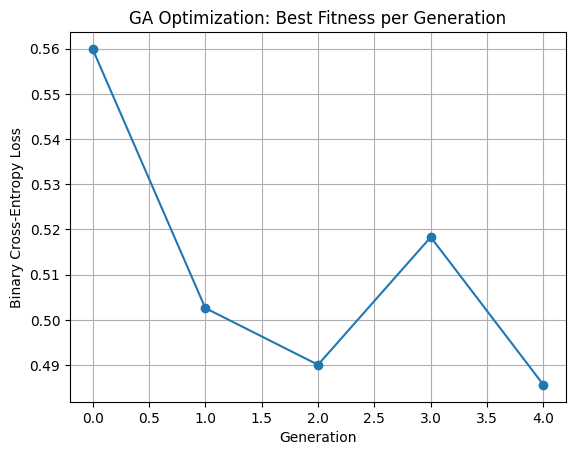

In [113]:
import matplotlib.pyplot as plt

plt.plot(best_fitness_per_gen, marker='o')
plt.title("GA Optimization: Best Fitness per Generation")
plt.xlabel("Generation")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True)
plt.show()

In [116]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(model, X_test, y_test, device):
    model.eval()

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze()
        predictions = (outputs > 0.5).float()  

    predictions = predictions.cpu().numpy()
    y_test_tensor = y_test_tensor.cpu().numpy()

    accuracy = accuracy_score(y_test_tensor, predictions)

    precision = precision_score(y_test_tensor, predictions)

    recall = recall_score(y_test_tensor, predictions)

    f1 = f1_score(y_test_tensor, predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1



In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate_metrics(model, X_test, y_test, device)

Accuracy: 0.8947
Precision: 0.8933
Recall: 0.9178
F1 Score: 0.9054


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_10940\3736339371.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


(0.8947368421052632,
 0.8933333333333333,
 0.9178082191780822,
 0.9054054054054054)